In [3]:
import numpy as np
import numpy.linalg as la
import random
import matplotlib.pyplot as plt
import math
from sklearn.utils.extmath import randomized_svd
import scipy.sparse as sp
import time
from time import perf_counter



### Rekurencyjny algorytm dekompresji

In [10]:
class MatrixTree:
    def __init__(self, matrix, x1, x2, y1, y2):
        self.matrix = matrix
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.leaf = False
        self.children = None


    def compress(self, r, eps):
        U, Sigma, V = randomized_svd(self.matrix[self.x1:self.x2, self.y1: self.y2], n_components=r+1, random_state=0)
        if self.x1 + r == self.x2 or Sigma[r] <= eps:
            self.leaf = True
            if not self.matrix[self.x1:self.x2, self.y1: self.y2].any():
                self.rank = 0
            else:
                self.rank = len(Sigma)
                self.u = U
                self.s = Sigma
                self.v = V
        else:
            self.children = []
            self.children.append(MatrixTree(self.matrix, self.x1, (self.x1 + self.x2)//2, self.y1, (self.y1 + self.y2)//2))
            self.children.append(MatrixTree(self.matrix, self.x1, (self.x1 + self.x2)//2, (self.y1 + self.y2)//2, self.y2))
            self.children.append(MatrixTree(self.matrix, (self.x1 + self.x2)//2, self.x2, self.y1, (self.y1 + self.y2)//2))
            self.children.append(MatrixTree(self.matrix, (self.x1 + self.x2)//2, self.x2, (self.y1 + self.y2)//2, self.y2))

            for child in self.children:
                child.compress(r, eps)
                
    def decompress(self, output_matrix):
        if self.leaf:
            if self.rank != 0:
                sigma = np.zeros((self.rank,self.rank))
                np.fill_diagonal(sigma, self.s)
                output_matrix[self.x1:self.x2, self.y1: self.y2] = self.u @ sigma @ self.v #zeros
            else:
                output_matrix[self.x1:self.x2, self.y1: self.y2] = self.matrix[self.x1:self.x2, self.y1: self.y2]
        else:
            for child in self.children:
                child.decompress(output_matrix)

### Funkcja rysująca obraz 


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def create_tree_image(root, title=''):
    image = np.ones(root.matrix.shape)*255
    Q = deque()
    Q.append(root)
    while Q:
        v = Q.pop()
        if v.leaf:
            image[v.x1:v.x2, v.y1:v.y1+v.rank] = np.zeros((v.x2 - v.x1, v.rank))
            image[v.x1:v.x1+v.rank, v.y1:v.y2] = np.zeros((v.rank , v.y2 - v.y1))
            image[v.x1, v.y1:v.y2] = np.zeros((1,v.y2 - v.y1))
            image[v.x2-1, v.y1:v.y2] = np.zeros((1,v.y2 - v.y1))
            image[v.x1:v.x2,v.y1] = np.zeros(v.x2-v.x1)
            image[v.x1:v.x2,v.y2-1] = np.zeros(v.x2-v.x1)
        else:
            for child in v.children:
                Q.append(child)
    return image

### Generowanie macierzy dla wybranych wartości procentowych

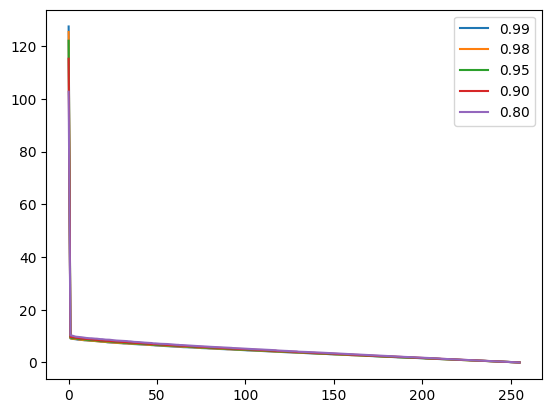

In [13]:
k = 2**8

test_matrixes = [sp.random(k,k,0.99).toarray(),
                   sp.random(k,k,0.98).toarray(),
                   sp.random(k,k,0.95).toarray(),
                   sp.random(k,k,0.90).toarray(),
                   sp.random(k,k,0.80).toarray()
                   ]
Vs = []
times = []
for M in test_matrixes:
    S,V,D = randomized_svd(M,n_components=k)
    Vs.append(V)

fig, ax = plt.subplots()
ax.plot(range(0,len(Vs[0])),Vs[0],label='0.99')
ax.plot(range(0,len(Vs[1])),Vs[1],label='0.98')
ax.plot(range(0,len(Vs[2])),Vs[2],label='0.95')
ax.plot(range(0,len(Vs[3])),Vs[3],label='0.90')
ax.plot(range(0,len(Vs[4])),Vs[4],label='0.80')
ax.legend()

### Uruchomienie SVD na wybranych macierzach i znalezienie wartości osobliwych

zeros=0.99, b=1, sigma=0, error=0.08291666804082243 time=1.827944708056748
zeros=0.98, b=1, sigma=0, error=0.08491797755138637 time=1.38472874998115
zeros=0.95, b=1, sigma=0, error=0.08904590580552046 time=1.2770081660710275
zeros=0.9, b=1, sigma=0, error=0.09492717169423259 time=1.4284109170548618
zeros=0.8, b=1, sigma=0, error=0.10410129579661186 time=1.2648183340206742
zeros=0.99, b=1, sigma=128, error=0.07040624447159685 time=1.7650969170499593
zeros=0.98, b=1, sigma=128, error=0.07220010264235983 time=1.8606303751002997
zeros=0.95, b=1, sigma=128, error=0.07583348705173493 time=2.1357842499855906
zeros=0.9, b=1, sigma=128, error=0.08062075967964666 time=1.7187488749623299
zeros=0.8, b=1, sigma=128, error=0.08848280261803702 time=1.8389497089665383
zeros=0.99, b=1, sigma=255, error=3.738328600091342e-33 time=47.39213562500663
zeros=0.98, b=1, sigma=255, error=8.61914773060191e-34 time=50.06916133291088
zeros=0.95, b=1, sigma=255, error=5.834189490652764e-34 time=47.24768545804545
z

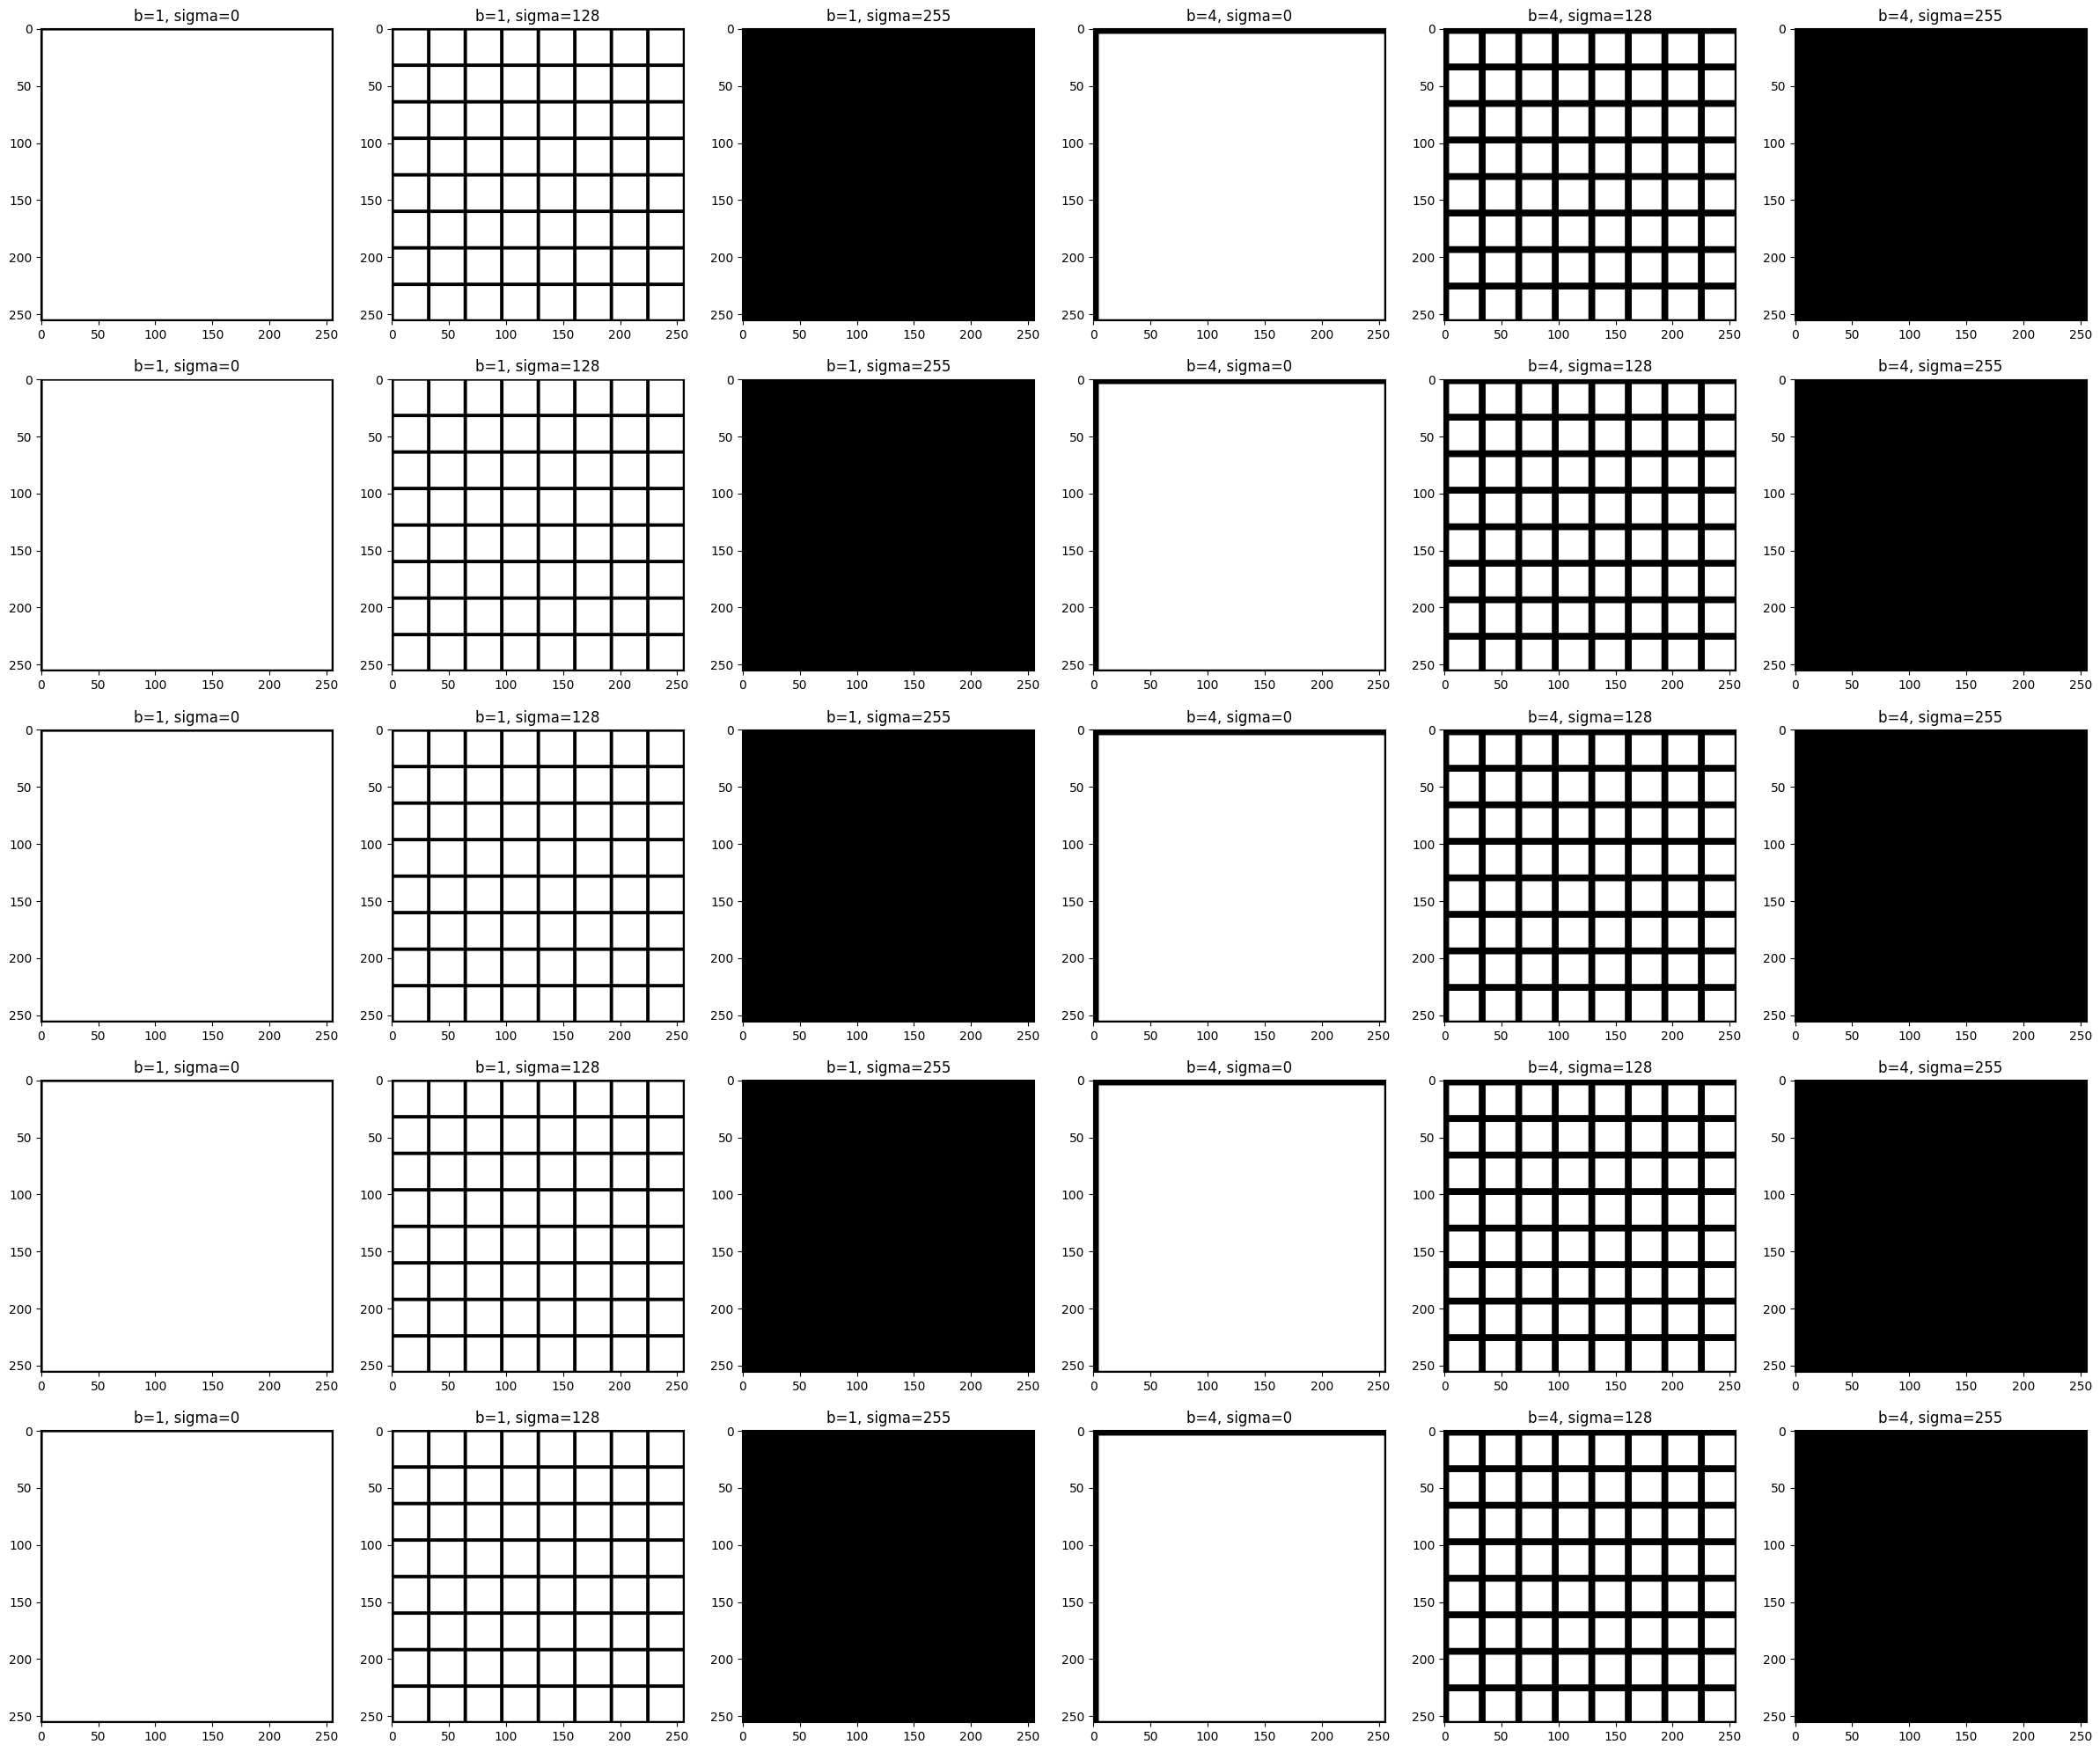

In [17]:
params = [(1,0),(1,k//2),(1,k-1),(4,0),(4,k//2),(4,k-1)]
sparse = [0.99,0.98,0.95,0.90,0.80]
maps = [[],[],[],[],[]]
times = []
fig, ax = plt.subplots(ncols=6,nrows=5,figsize=(5*6,5*5))
for index,(b,sigma) in enumerate(params):
    for i in range(0,5):
        root = MatrixTree(test_matrixes[i],0,k,0,k)
        start = perf_counter()
        root.compress(b,Vs[i][sigma])
        end = perf_counter()
        maps[i].append(create_tree_image(root))
        times.append(end-start)
        output_matrix = np.zeros((k,k))
        root.decompress(output_matrix)
        error = np.mean(np.square(test_matrixes[i] - output_matrix))
        ax[i,index].imshow(maps[i][index],cmap='gist_gray',vmin=0,vmax=255)
        ax[i,index].set_title(f'b={b}, sigma={sigma}')
        print(f'zeros={sparse[i]}, b={b}, sigma={sigma}, error={error} time={end-start}')

,"(1, 0)","(1, 128)","(1, 255)","(4, 0)","(4, 128)","(4, 255)"
0.99,1.83,1.38,1.28,1.43,1.26,1.77
0.98,1.86,2.14,1.72,1.84,47.39,50.07
0.95,47.25,57.11,47.63,1.21,1.55,1.28
0.90,1.34,1.45,1.66,1.54,2.35,1.76
0.80,2.45,9.25,7.26,6.07,9.60,8.52


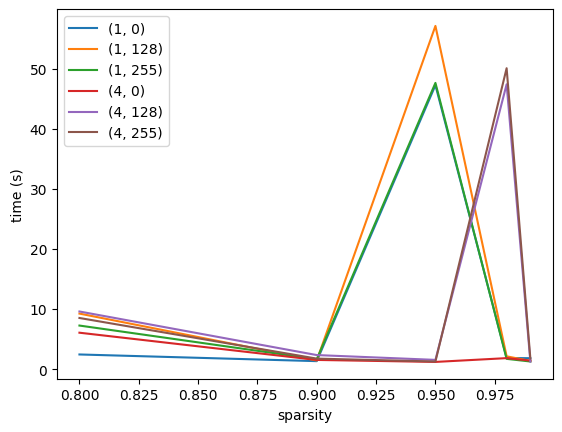

In [28]:
import pandas as pd
df = pd.DataFrame(np.array(times).round(2).reshape(5,6),columns=[(1,0),(1,k//2),(1,k-1),(4,0),(4,k//2),(4,k-1)],index=[0.99,0.98,0.95,0.90,0.80])
plt.plot(df)
plt.legend(df.columns)
plt.xlabel('sparsity')
plt.ylabel('time (s)')
df

### Wnioski:
* Zwiększenie b - mniejszy błąd, dłuższy czas 
* Zmniejszenie sigma - mniejszy błąd, dłuszy czas